In [22]:
import pickle
import torch
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
import sys
sys.path.append("../../..")

from datasets.morpho_mnist.dataset import ImageDataset, MetadataDataset
from auto_localization.models.BasicVAE import BasicVAE
from auto_localization.plotting.localization import save_localization_metadata_distance_plots

In [4]:
model_dir = "../../logs/vivid-lake-1138"
os.listdir(model_dir)

['model.pkl', 'localizers.pkl', 'params.pkl', 'localizer_metrics.pkl']

In [5]:
image_data = ImageDataset()

In [6]:
def load_objects(model_dir):
    # load localizers
    with open(model_dir+"/localizers.pkl", "rb") as f:
        localizers = pickle.load(f)
    # load metrics
    with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
        localizer_metrics = pickle.load(f)
    # load config 
    with open(model_dir+"/params.pkl", "rb") as f:
        config = pickle.load(f)
    print(config)
    # load model
    model_path = model_dir+"/model.pkl"
    z_dim = config["model_config"]["latent_dim"]
    in_shape = config["model_config"]["in_shape"]
    d = config["model_config"]["d"]
    layer_count = config["model_config"]["layer_count"]
    channels = config["model_config"]["channels"]
    model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels)
    model.load_state_dict(torch.load(model_path))
    model.to("cuda")
    model.eval()
        
    return localizers, localizer_metrics, model, config

In [7]:
localizers, localizer_metrics, model, config = load_objects(model_dir)

{'trials': 1, 'epochs': 100, 'lr': 0.001, 'batch_size': 128, 'trainer': 'triplet', 'localization_config': {'indexed': False, 'trials': 10, 'k': 1.0, 'localizer_type': 'MCMV', 'num_queries': 10}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.001, 'triplet_beta': 0.0, 'triplet_margin': 1.0, 'warm_start': 50, 'kl_max': 0.001}, 'dataset_config': {'component_weighting': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0}}


## Plots


In [30]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

Error: You must call wandb.init() before wandb.log()

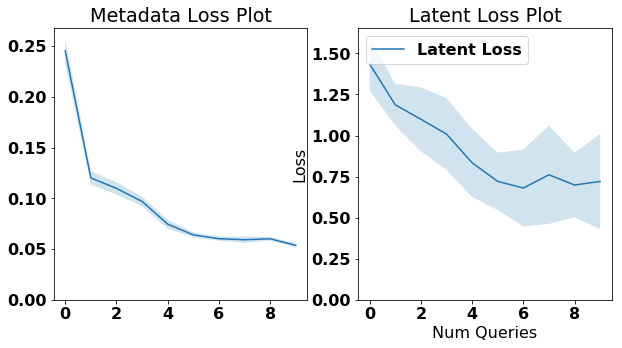

In [32]:
# plot the localization rollouts

save_localization_metadata_distance_plots(localizer_metrics)
plt.show()

In [8]:
# plot an image sampling of the latent space
# embed all the images from the test image dataset
embedding = []
for image in image_data:
    embedding_mean, _ = model.encode(image).detach().cpu().numpy()
    embedding.append(embedding_mean)
    
plot_binned_tsne_grid(embedding, embedding, model, num_channels=1, dpi=500, num_x_bins=15, num_y_bins=15, title="")
plt.show()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
# plot the loss over time

In [ ]:
# plot the metadata loss corresponding to the localization rollotus

In [ ]:
# plot a grid of reconstructions

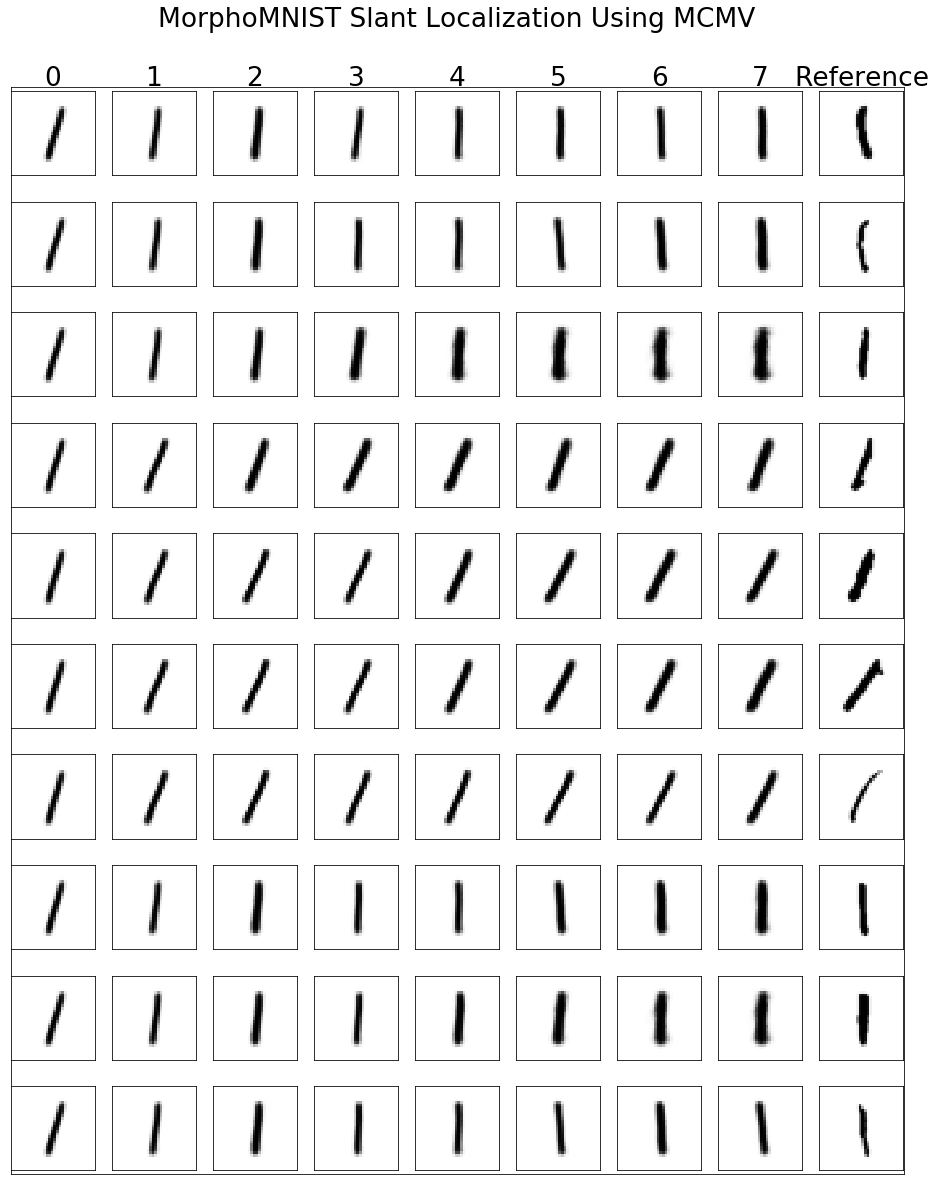

In [26]:
# plot a localization path
model.eval()
num_localizers = len(localizers)
num_queries = min(len(localizers[0].posterior_means), 8)
fig = plt.figure(figsize=(2*num_queries, 2*num_localizers))
plt.title("MorphoMNIST Slant Localization Using MCMV",  y=1.05)
plt.xticks([])
plt.yticks([])

for i, localizer in enumerate(localizers):
    for j, mean in enumerate(localizer.posterior_means[0:num_queries]):
        ax = fig.add_subplot(num_localizers, num_queries + 1, i * (num_queries + 1) + j + 1)
        if i == 0:
            ax.set_title(f"{j}")
        # decode mean
        mean = torch.Tensor(mean)[None, :]
        decoded_mean = model.decode(mean.to("cuda")).cpu().detach().numpy().squeeze()
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(decoded_mean, cmap='gray_r')
    # show reference image
    ax = fig.add_subplot(num_localizers, num_queries + 1, i * (num_queries + 1) + j + 2)
    if i == 0:
        ax.set_title("Reference")
    ax.set_yticks([])
    ax.set_xticks([])

    reference_image = localizer.reference_data
    ax.imshow(reference_image, cmap='gray_r')
plt.show()


In [ ]:
# plot average localization paths

In [ ]:
# plot morpho mnist dataset morphometric distributions
# I want to know how low should we be able to get for different features

## Metadata Stats

(6742, 6)


(array([  2.,   6.,   7.,  13.,  56., 148., 345., 581., 712., 711., 732.,
        658., 723., 698., 576., 435., 219.,  96.,  22.,   2.]),
 array([0.        , 0.08653993, 0.17307986, 0.25961979, 0.34615972,
        0.43269965, 0.51923958, 0.60577951, 0.69231944, 0.77885937,
        0.8653993 , 0.95193923, 1.03847916, 1.12501909, 1.21155902,
        1.29809895, 1.38463888, 1.47117881, 1.55771874, 1.64425867,
        1.7307986 ]),
 <a list of 20 Patch objects>)

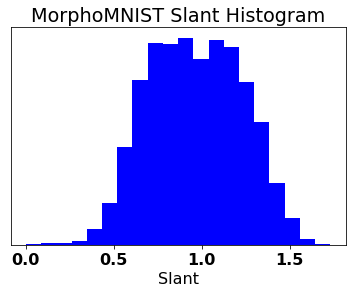

In [45]:
metadata_dataset = MetadataDataset(which_digits=[1])
print(np.shape(metadata_dataset.metadata))
plt.title("MorphoMNIST Slant Histogram")
plt.yticks([])
plt.xlabel("Slant")
plt.hist(metadata_dataset.metadata[:, 3], bins=20, color = "blue")